Context (Client Legacy Strategy):
The client currently operates battery assets using a simple rule-based trading strategy that charges during low-price hours and discharges during high-price hours using static price thresholds.

Objective: Optimise the charge and discharge behaviour of a battery asset to capture intraday electricity price volatility and maximise trading profit under physical constraints.

Battery assumptions:
Capacity: 2 MWh
Max charge/discharge rate: 1 MW
Efficiency: 90%
No degradation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load price data
prices = pd.read_csv("../data/raw/prices.csv")
prices["datetime"] = pd.to_datetime(prices["datetime"])
prices = prices.set_index("datetime")

price_series = prices["price"].values
T = len(price_series)


In [2]:
# Battery parameters
capacity = 2.0          # MWh
max_power = 1.0         # MW
efficiency = 0.9

# Time step (1 hour)
dt = 1


In [3]:
state_of_charge = 0.0
soc = []
charge = []
discharge = []
profit = []

for t in range(T):
    price = price_series[t]

    # Simple strategy:
    # Charge when price below daily median
    # Discharge when price above daily median
    median_price = np.median(price_series)

    if price < median_price and state_of_charge < capacity:
        energy = min(max_power * dt, capacity - state_of_charge)
        state_of_charge += energy * efficiency
        charge.append(energy)
        discharge.append(0)
        profit.append(-energy * price)

    elif price > median_price and state_of_charge > 0:
        energy = min(max_power * dt, state_of_charge)
        state_of_charge -= energy
        charge.append(0)
        discharge.append(energy)
        profit.append(energy * price)

    else:
        charge.append(0)
        discharge.append(0)
        profit.append(0)

    soc.append(state_of_charge)


In [4]:
results = prices.copy()
results["charge_MWh"] = charge
results["discharge_MWh"] = discharge
results["state_of_charge"] = soc
results["profit"] = profit

results, results["profit"].sum()


(                     price  charge_MWh  discharge_MWh  state_of_charge  \
 datetime                                                                 
 2024-01-01 00:00:00     45     1.00000       0.000000         0.900000   
 2024-01-01 01:00:00     42     1.00000       0.000000         1.800000   
 2024-01-01 02:00:00     40     0.20000       0.000000         1.980000   
 2024-01-01 03:00:00     38     0.02000       0.000000         1.998000   
 2024-01-01 04:00:00     37     0.00200       0.000000         1.999800   
 2024-01-01 05:00:00     39     0.00020       0.000000         1.999980   
 2024-01-01 06:00:00     50     0.00002       0.000000         1.999998   
 2024-01-01 07:00:00     65     0.00000       1.000000         0.999998   
 2024-01-01 08:00:00     75     0.00000       0.999998         0.000000   
 2024-01-01 09:00:00     80     0.00000       0.000000         0.000000   
 2024-01-01 10:00:00     78     0.00000       0.000000         0.000000   
 2024-01-01 11:00:00     

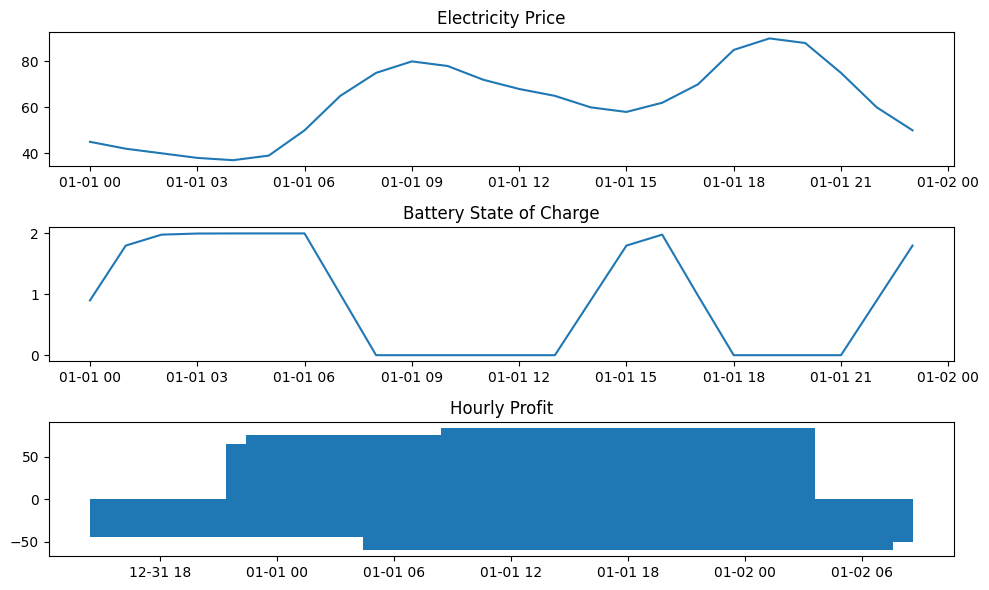

In [5]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(results.index, results["price"])
plt.title("Electricity Price")

plt.subplot(3, 1, 2)
plt.plot(results.index, results["state_of_charge"])
plt.title("Battery State of Charge")

plt.subplot(3, 1, 3)
plt.bar(results.index, results["profit"])
plt.title("Hourly Profit")

plt.tight_layout()
plt.show()


Insight: The battery consistently charges during low-price overnight hours and discharges during morning and evening peaks, demonstrating how price volatility creates arbitrage value for flexible assets.

Hourly profit graph is difficult to read so below i have include a cumulative profit graph and a colour coded costs vs revenue chart

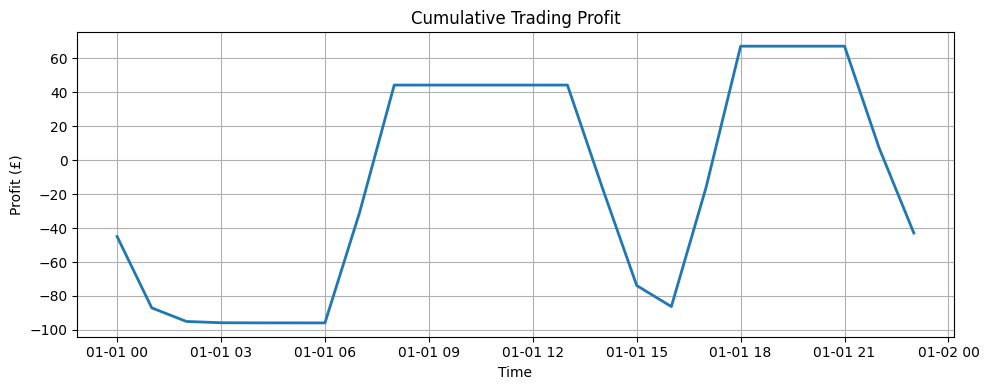

In [ ]:
# Cumulative profit
results["cumulative_profit"] = results["profit"].cumsum()

plt.figure(figsize=(10, 4))
plt.plot(results.index, results["cumulative_profit"], linewidth=2)
plt.title("Cumulative Trading Profit")
plt.ylabel("Profit (£)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


shows current strat is not profitable ends just below -40 in cumulative profit.

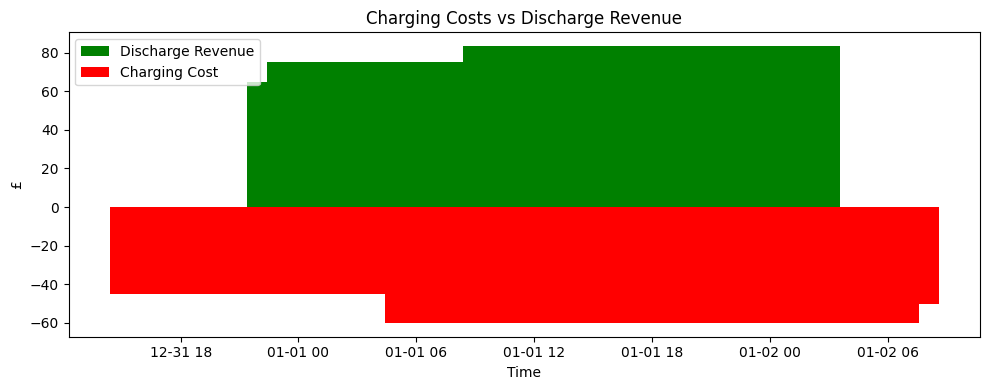

In [7]:
plt.figure(figsize=(10, 4))

plt.bar(
    results.index,
    results["discharge_MWh"] * results["price"],
    label="Discharge Revenue",
    color="green"
)

plt.bar(
    results.index,
    -results["charge_MWh"] * results["price"],
    label="Charging Cost",
    color="red"
)

plt.title("Charging Costs vs Discharge Revenue")
plt.ylabel("£")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


While intuitive, this strategy leads to inefficient cycling and can result in negative cumulative profit, motivating the need for optimisation.